# Evaluations for maximum likelihood

## 1. Actual data likelihood
## 2. Amari distance

In [60]:
import jax
from jax import numpy as jnp
import numpy as np
import distrax
import haiku as hk
from residual import TriangularResidual, spectral_norm_init, spectral_normalization, masks_triangular_weights, make_weights_triangular, LipSwish

from jax.experimental.optimizers import adam

In [61]:
key = jax.random.PRNGKey(1)

## Generate data

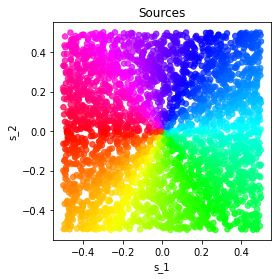

In [62]:
# N:=Number of samples
N = 3000
# D:=Number of dimensions
D = 2

# Generate the samples
S = jax.random.uniform(key, shape=(N, D), minval=0.0, maxval=1.0)

S -= 0.5


from plotting import cart2pol, scatterplot_variables

_, colors = cart2pol( S[:,0], S[:,1])

# Plot the sources
scatterplot_variables(S, 'Sources', colors=colors, savefig=False)

In [63]:
# from mixing_functions import build_conformal_map
# nonlinearity = lambda x : jnp.exp(1.3*x)
# mixing, mixing_gridplot = build_conformal_map(nonlinearity)

from mixing_functions import build_moebius_transform

# Generate a random orthogonal matrix
from scipy.stats import ortho_group # Requires version 0.18 of scipy

A = ortho_group.rvs(dim=D)

# Scalar
alpha = 3.5
# Two vectors with data dimensionality
a = np.array([2.1, 3.5]) #2.0 * np.ones(D) # a vector in \RR^D
b = 3.0 * np.ones(D) # a vector in \RR^D

from jax import vmap
mixing_moebius, unmixing_moebius = build_moebius_transform(alpha, A, a, b, epsilon=0)
mixing_batched = vmap(mixing_moebius)

from jax import vmap

mixing_batched = vmap(mixing_moebius)

In [64]:
# X = S @ A

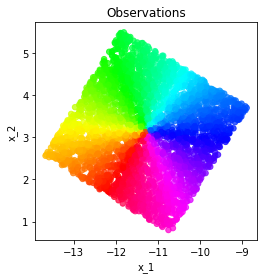

In [65]:
X = mixing_batched(S)
# X -= jnp.mean(X, axis=0)
# X /= jnp.std(X, axis=0)

scatterplot_variables(X, 'Observations', colors=colors, savefig=False)#True, fname="observations_flow")

In [66]:
unmixing_batched = vmap(unmixing_moebius)

In [67]:
Y = unmixing_batched(X)

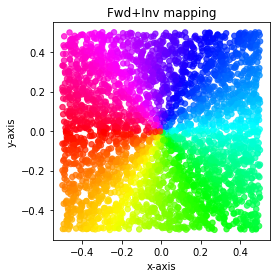

In [68]:
scatterplot_variables(Y, 'Fwd+Inv mapping', colors=colors, savefig=False)#True, fname="observations_flow")

## 1. Compute the true data likelihood

In [69]:
def observed_data_likelihood(x, unmixing):
    # log-det-Jac of the unimxing
    Jac = jax.jacfwd(unmixing)
    jac = Jac(x)
    return jnp.linalg.slogdet(jac)[1] # + log_pdf_base(unmixing(x))

In [70]:
# observed_data_likelihood(X[0], unmixing_moebius)

In [71]:
observed_likelihood_batched = vmap(lambda y: observed_data_likelihood(y, unmixing_moebius))

In [72]:
obs_likel = observed_likelihood_batched(X)

In [73]:
jnp.mean(obs_likel)

DeviceArray(-2.5055244, dtype=float32)

## Set up model

In [74]:
n_layers = 10 #32
hidden_units = [40, 40] #[128, 128]

# I would substitute the Normal with a Logistic distribution

def log_prob(x):
    base_dist = distrax.Independent(distrax.Logistic(loc=jnp.zeros(2), scale=jnp.ones(2)),
                                                    reinterpreted_batch_ndims=1)
    flows = distrax.Chain([TriangularResidual(hidden_units + [2], name='residual_' + str(i))
                           for i in range(n_layers)])
    model = distrax.Transformed(base_dist, flows)
    return model.log_prob(x)

In [75]:
# Init model
logp = hk.transform(log_prob)
params = logp.init(key, jnp.array(np.random.randn(5, 2)))

In [76]:
# In ML + C_IMA, we don't want triangular Jacobian! I comment out the below

# # Make triangular
# masks = masks_triangular_weights([h // 2 for h in hidden_units])
# params = make_weights_triangular(params, masks)

In [77]:
# This is one part of the loss!
# Copied over from the triangular_residual_flow_test notebook

def inv_map_fn(x):
    flows = distrax.Chain([TriangularResidual(hidden_units + [2], name='residual_' + str(i))
                           for i in range(n_layers)])
    return flows.inverse(x)

inv_map = hk.transform(inv_map_fn)

def cima(x, params):
    jac_fn = jax.vmap(jax.jacfwd(lambda y: inv_map.apply(params, None, y)))
    J = jac_fn(x)
    detJ = J[:, 0, 0] * J[:, 1, 1] - J[:, 0, 1] * J[:, 1, 0]
    out = jnp.sum(jnp.log(jnp.linalg.norm(J, axis=2)), axis=1) - jnp.log(jnp.abs(detJ))
    return out

In [78]:
# Apply spectral normalization

uv = spectral_norm_init(params, key)
params, uv = spectral_normalization(params, uv)

In [79]:
# Define a Lagrange multiplier to be multiplied before the c_ima contrast
lag_mult = 0.0

def loss(params, x):
    ll = logp.apply(params, None, x)
    c_ima = cima(x, params)
    return -jnp.mean(ll) + lag_mult * jnp.mean(c_ima)

Model training

In [80]:
opt_init, opt_update, get_params = adam(step_size=1e-3)

@jax.jit
def step(it, opt_state, uv, x):
    params = get_params(opt_state)
#     params = make_weights_triangular(params, masks) # makes Jacobian triangular
    params, uv = spectral_normalization(params, uv)
    params_flat = jax.tree_util.tree_flatten(params)[0]
    for ind in range(len(params_flat)):
        opt_state.packed_state[ind][0] = params_flat[ind]
    value, grads = jax.value_and_grad(loss, 0)(params, x)
    opt_out = opt_update(it, grads, opt_state)
    return value, opt_out, uv

In [81]:
iters, batch_size = 50000, 256

opt_state = opt_init(params)

loss_hist = np.array([])

In [82]:
for i in range(iters):
    x = X[np.random.choice(X.shape[0], batch_size)]
    value, opt_state, uv = step(i, opt_state, uv, x)
    loss_hist = np.append(loss_hist, value.item())
    if i%2000==0:
        print("iter=", i, "; loss=", value.item())

iter= 0 ; loss= 14.516080856323242
iter= 2000 ; loss= 2.819952964782715
iter= 4000 ; loss= 2.6526787281036377
iter= 6000 ; loss= 2.6467747688293457
iter= 8000 ; loss= 2.591287136077881
iter= 10000 ; loss= 2.5768206119537354
iter= 12000 ; loss= 2.5593318939208984
iter= 14000 ; loss= 2.5805041790008545
iter= 16000 ; loss= 2.5325803756713867
iter= 18000 ; loss= 2.5493359565734863
iter= 20000 ; loss= 2.5457541942596436
iter= 22000 ; loss= 2.51904034614563
iter= 24000 ; loss= 2.517148971557617
iter= 26000 ; loss= 2.518444538116455
iter= 28000 ; loss= 2.5190958976745605
iter= 30000 ; loss= 2.516094207763672
iter= 32000 ; loss= 2.5133025646209717
iter= 34000 ; loss= 2.5250134468078613
iter= 36000 ; loss= 2.6293458938598633
iter= 38000 ; loss= 2.5602059364318848
iter= 40000 ; loss= 2.560999870300293
iter= 42000 ; loss= 2.6168980598449707
iter= 44000 ; loss= 2.5550897121429443
iter= 46000 ; loss= 2.5540688037872314
iter= 48000 ; loss= 2.554591655731201


In [83]:
params_final = get_params(opt_state)
# params_final = make_weights_triangular(params_final, masks)
params_final, _ = spectral_normalization(params_final, uv)

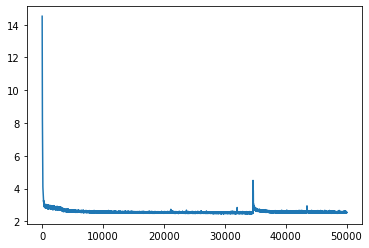

In [84]:
from matplotlib import pyplot as plt

plt.plot(loss_hist)

In [85]:
def inv_map_fn(x):
    flows = distrax.Chain([TriangularResidual(hidden_units + [2], name='residual_' + str(i))
                           for i in range(n_layers)])
    return flows.inverse(x)
inv_map = hk.transform(inv_map_fn)

In [86]:
S_rec = inv_map.apply(params_final, None, X)

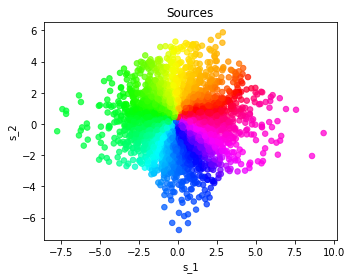

In [87]:
scatterplot_variables(S_rec, 'Sources', colors=colors, savefig=False)

In [88]:
from jax.scipy.stats import logistic

In [89]:
S_unif = logistic.cdf(S_rec) # use the Logistic cdf here!

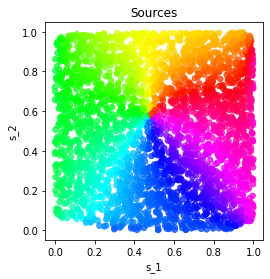

In [90]:
scatterplot_variables(S_unif, 'Sources', colors=colors, savefig=False)

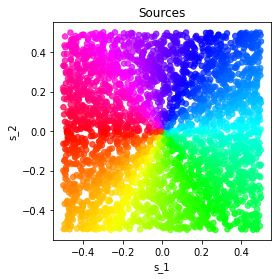

In [91]:
scatterplot_variables(S, 'Sources', colors=colors, savefig=False)

## Compute CIMA

In [92]:
def cima(x):
    jac_fn = jax.vmap(jax.jacfwd(lambda y: inv_map.apply(params_final, None, y)))
    J = jac_fn(x)
    detJ = J[:, 0, 0] * J[:, 1, 1] - J[:, 0, 1] * J[:, 1, 0]
    out = jnp.sum(jnp.log(jnp.linalg.norm(J, axis=2)), axis=1) - jnp.log(jnp.abs(detJ))
    return out

In [93]:
c = cima(X)

In [94]:
jnp.mean(c)

DeviceArray(0.23018424, dtype=float32)

In [95]:
# Check that the Jacobian is **not** triangular
jac_fn = jax.vmap(jax.jacfwd(lambda y: inv_map.apply(params_final, None, y)))
J = jac_fn(X)
# J.shape
mean_J = np.mean(J, axis=0)
# mean_J.shape
print(mean_J)

[[ 0.09716926 -2.7631931 ]
 [-2.8435237  -0.3002978 ]]


In [96]:
# Use the Amari distance for evaluation

## Amari distance evaluation

In [97]:
def amari_distance_average(W, A):
    """
    Based on:
    https://github.com/pierreablin/picard/blob/master/picard/_tools.py
    
    Computes the Amari distance between the average of the products of two collections of matrices W and A.
    It cancels when WA is a permutation and scale matrix.
    Parameters
    ----------
    W : ndarray, shape (n_samples, n_features, n_features)
        Input collection of matrices
    A : ndarray, shape (n_samples, n_features, n_features)
        Input collection of matrices
    Returns
    -------
    d : ndarray, shape (n_samples, )
        The Amari distances between the average of the products of W and A.
    """
#     P = np.matmul(W, A)

    P = np.sum(np.matmul(W, A), axis=0)
    print(P.shape)

    def s(r):
        return np.sum(np.sum(r ** 2, axis=-1) / np.max(r ** 2, axis=-1) - 1, axis=-1)
    return (s(np.abs(P)) + s(np.abs(P.T))) / (2 * P.shape[1])
#     return (s(np.abs(P)) + s(np.abs(np.transpose(P, (0, 2, 1))))) / (2 * P.shape[1])

## Rather than the average of the Amari distances between the products of the Jacobians, we should take the Amari distance of the average of the products of the Jacobians.
## Otherwise it is hard to account for the fact that the Permutation matrix might be different at different locations

In [98]:
def jacobian_amari_distance(x, jac_r_unmix, jac_t_mix, unmixing_batched):

    J_r_unmix = jax.vmap(jac_r_unmix)(x)
    J_t_mix = jax.vmap(jac_t_mix)(unmixing_batched(x))
    
    return amari_distance(J_r_unmix, J_t_mix)

In [99]:
jac_r_unmix = jax.jacfwd(lambda y: inv_map.apply(params_final, None, y))
# jac_r_unmix = jax.jacfwd(unmixing_moebius)
jac_t_mix = jax.jacfwd(mixing_moebius)

In [100]:
jad = jacobian_amari_distance(X, jac_r_unmix, jac_t_mix, unmixing_batched)

(2, 2)


In [101]:
print(jnp.mean(jad))
print(jnp.median(jad))

0.5142164
0.5142164


In [102]:
jnp.max(jad)

DeviceArray(0.5142164, dtype=float32)

In [103]:
jnp.min(jad)

DeviceArray(0.5142164, dtype=float32)

In [104]:
# To do: Visualize the distortion from original sources to reconstructed ones?
# Maybe with a gridplot?